Источник: https://www.kaggle.com/datafiniti/hotel-reviews?select=Datafiniti_Hotel_Reviews_Jun19.csv

In [1]:
import pandas as pd
from nltk import word_tokenize
import matplotlib.pyplot as plt
from langdetect import detect
from tqdm import tqdm
import numpy as np

In [15]:
df1 = pd.read_csv('Datafiniti_Hotel_Reviews.csv')
df2 = pd.read_csv('Datafiniti_Hotel_Reviews_Jun19.csv')

Уникальные отзывы:

In [16]:
len(set(df1['reviews.text'].tolist() + df2['reviews.text'].tolist()))

19660

In [17]:
df = pd.concat([df1, df2])

Убираем дубли.

In [18]:
df.shape == df.drop_duplicates(['id', 'reviews.text']).shape

False

In [19]:
df = df.drop_duplicates(['id', 'reviews.text'])

Убираем пустые значения вместо текста ревью.

In [20]:
df[df['reviews.text'].isna()]

,id,dateAdded,dateUpdated,address,categories,primaryCategories,city,country,keys,latitude,...,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sourceURLs,websites,reviews.dateAdded
6723,AVwcmcqPkufWRAb5w-y1,2015-10-23T22:32:31Z,2018-03-06T00:33:22Z,250 Spring St,"Hotel,Hotels and motels",Accommodation & Food Services,Charleston,US,us/sc/charleston/250springst/-518306969,32.786271,...,3.0,https://www.expedia.com/Charleston-Hotels-Holi...,NaN,Review,NaN,NaN,A verified traveler,https://foursquare.com/v/holiday-inn-express-c...,https://www.ihg.com/holidayinnexpress/hotels/u...,NaN


In [21]:
df = df.dropna(subset=['reviews.text'], axis=0)

Обработаем категории. Оставим только Accommodation & Food Services для более узкой тематики.

In [22]:
df.groupby('primaryCategories').count()

,id,dateAdded,dateUpdated,address,categories,city,country,keys,latitude,longitude,...,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sourceURLs,websites,reviews.dateAdded
primaryCategories,,,,,,,,,,,,,,,,,,,,,
Accommodation & Food Services,19603,19603,19603,19603,19603,19603,19603,19603,19603,19603,...,19603,19603,19603,19601,13805,12352,19603,19603,19603,0
"Accommodation & Food Services,Administrative & Support & Waste Management & Remediation",1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
"Accommodation & Food Services,Agriculture",1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
"Accommodation & Food Services,Arts Entertainment & Recreation",8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,7,7,8,8,8,0
Arts Entertainment & Recreation,45,45,45,45,45,45,45,45,45,45,...,45,45,45,45,18,15,45,45,45,0
"Healthcare & Social Assistance,Accommodation & Food Services",18,18,18,18,18,18,18,18,18,18,...,18,18,18,18,15,10,18,18,18,0
Utilities,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
"Wholesale Trade,Accommodation & Food Services",7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,5,4,7,7,7,0


In [23]:
df = df[df['primaryCategories'] == 'Accommodation & Food Services']

Некоторые отзывы свернуты и имеют "... More" в конце. Уберем такие отзывы.

In [24]:
def func(text):
    if '... More' in text:
        return False
    else:
        return True

df['is_full'] = df['reviews.text'].transform(lambda x: func(x))

In [25]:
df[df['is_full'] == True].shape

(15562, 27)

In [26]:
df = df[df['is_full'] == True]

Проверим язык и оставим только английский.

In [27]:
def func(x):
    try:
        return detect(x)
    except Exception:
        return 'no lang'

df['lang'] = np.nan
for num, row in tqdm(df.iterrows()):
    lang = func(row['reviews.text'])
    df.loc[num, 'lang'] = lang

15562it [01:30, 171.58it/s]


In [28]:
df[df['lang'] == 'en'].shape

(15493, 28)

In [30]:
df = df[df['lang'] == 'en']

Токенизируем.

In [31]:
df['reviews.text.tokens'] = df['reviews.text'].transform(lambda x: word_tokenize(x))

Считаем длину текстов.

In [32]:
df['reviews.length'] = df['reviews.text.tokens'].transform(lambda x: len(x))

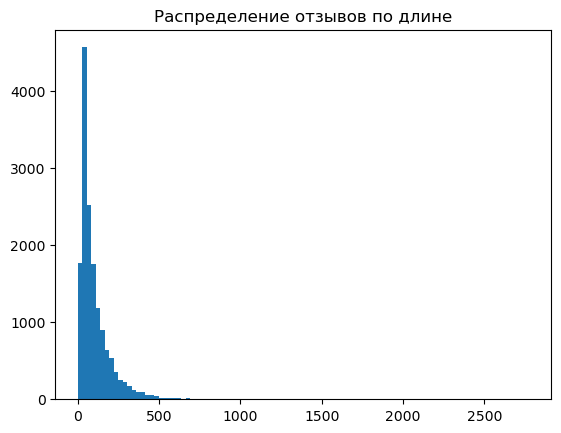

In [33]:
plt.hist(df['reviews.length'].tolist(), bins=100)
plt.title('Распределение отзывов по длине')
plt.show()

### Подготовим данные для дообучения GPT.

Уберем слишком короткие отзывы.

In [36]:
df_gpt = df[df['reviews.length'] >= 20]
df_gpt.shape

(14362, 30)

Распределение по рейтингу.

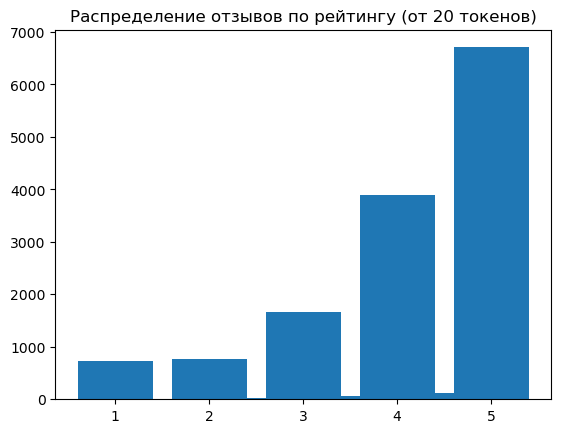

In [38]:
barchart = df_gpt[['reviews.rating', 'reviews.text']].groupby(['reviews.rating']).count()
plt.bar(height=barchart['reviews.text'], x=barchart.index)
plt.title('Распределение отзывов по рейтингу (от 20 токенов)')
plt.show()

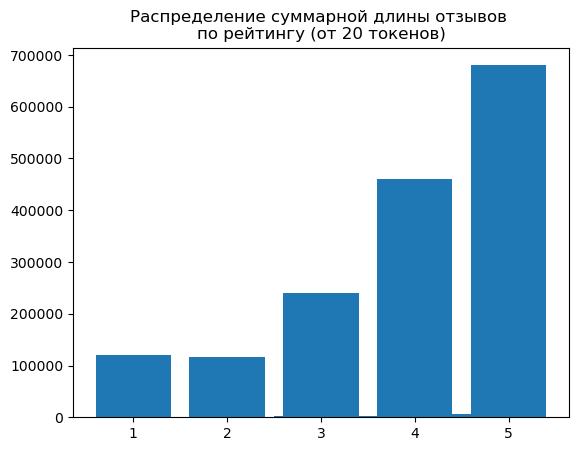

In [55]:
barchart = df_gpt[['reviews.rating', 'reviews.length']].groupby(['reviews.rating']).sum()
plt.bar(height=barchart['reviews.length'], x=barchart.index)
plt.title('Распределение суммарной длины отзывов \nпо рейтингу (от 20 токенов)')
plt.show()

Предлагаю взять следующие пороги:

In [85]:
df_gpt[df_gpt['reviews.rating'] <= 3].shape

(3241, 30)

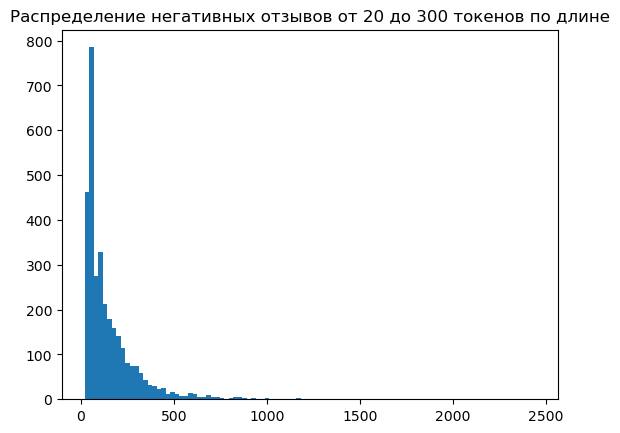

In [86]:
plt.hist(df_gpt[df_gpt['reviews.rating'] <= 3]['reviews.length'].tolist(), bins=100)
plt.title('Распределение негативных отзывов от 20 до 300 токенов по длине')
plt.show()

In [87]:
df_gpt[df_gpt['reviews.rating'] == 5].shape

(6708, 30)

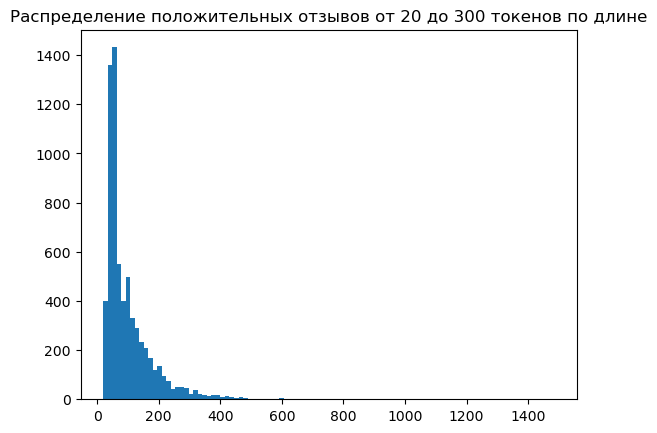

In [88]:
plt.hist(df_gpt[df_gpt['reviews.rating'] == 5]['reviews.length'].tolist(), bins=100)
plt.title('Распределение положительных отзывов от 20 до 300 токенов по длине')
plt.show()

In [89]:
df_gpt.to_csv('reviews_gpt.csv', sep='\t', index=False)

Рассмотрим отзывы любой длины и их разбивку по отелям:

In [47]:
hotels = df_gpt[['id', 'reviews.text']].groupby('id').count().sort_values('reviews.text', ascending=False)

In [53]:
hotels[hotels['reviews.text'] >= 2]

,reviews.text
id,
AVwcgshl_7pvs4fzv3ge,195
AVweG6e1_7pvs4fzAG7n,157
AWE7bZc53-Khe5l_f3pJ,144
AVweB_oFByjofQCxuqx2,143
AVwdmGkmIN2L1WUfxXj-,136
...,...
AVwd87J3_7pvs4fz-ta8,2
AVwc9q-HByjofQCxkFoy,2
AVwc_YIF_7pvs4fz1Gha,2


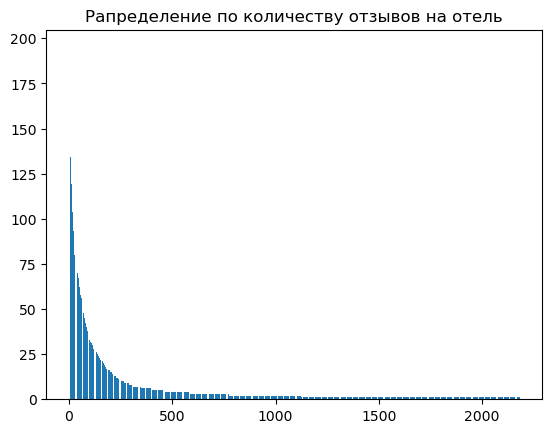

In [54]:
plt.bar(x=[i for i in range(0, hotels.shape[0])], height=hotels['reviews.text'])
plt.title('Рапределение по количеству отзывов на отель')
plt.show()

In [92]:
df.to_csv('reviews.csv', sep='\t', index=False)